# Augmenting and Ingesting Training Images

This notebook largely contains the following four things:
1. Finding the mean activity of all the processed training image and saving it (this step is a continuation from `preprocessing_playground.ipynb`.
2. Randomly sampling 1024 unique portions of all training images, horizontally flipping them, and returning the output (this step increases the training data by a factor of 2048, as described in the [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)).
3. Principal Component Analysis of the RGB pixel values, so that the following quantity $\mathrm{[\textbf{p}_1, \, \textbf{p}_2, \, \textbf{p}_3] [\alpha_1 \lambda_1, \, \alpha_2 \lambda_2, \, \alpha_3 \lambda_3]^{T}}$ can be added to all the pixels.
4. Training Labels: storing the training label wordnet IDs, synsets, and lemmas as a CSV.

The final, polished functions/code will be compiled in a separate python script where the model will be executed. 

In [6]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import shutil
import torchvision.transforms as transforms 
import time
from matplotlib.animation import FuncAnimation
from plotting_preferences import plotting_preferences_AS
from torchvision.transforms import v2
import torchvision.transforms.functional as F
import itertools
from numpy.linalg import eig
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import polars as pl
from nltk.corpus import wordnet as wn
import nltk
import scipy.io

In [2]:
random.seed(234213) #(7923478)
plotting_preferences_AS()

### 0. Loading the processed 256 x 256 images

In [3]:
training_images_output_path = "./images/training_images_processed/"

training_images_processed_path = [
    training_images_output_path + f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]    

training_images_processed_names = [
    f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]   

print(len(training_images_processed_path))

1261405


#### 0.1 Ensuring all images have three channels

In [5]:
try:
    os.mkdir("./images/non_rgb_images/")
except FileExistsError:
    pass

non_rgb_images_directory = "./images/non_rgb_images/"

In [7]:
# checking the different types of non-RGB images present
# I feel there could be 2-channel images, and not just greyscales
# this ended up being not that helpful for the code below, but still interesting
print(set([Image.open(i).mode for i in training_images_processed_path if Image.open(i).mode != "RGB"]))

{'CMYK', 'L'}


In [9]:
# should be ~0.2% of the entire training set assuming the 
# subset used in preprocessing.ipynb was a representative sample
total_non_rgb = 0

for i in tqdm(training_images_processed_path):
    image = Image.open(i)
    
    if image.mode != "RGB":
        total_non_rgb += 1

        # copying the non-RGBs to another folder
        shutil.copy(i, f"./images/non_rgb_images/")

        # converting to a three channel image 
        # and saving it in-place of the old one
        three_channel_image = image.convert("RGB")
        three_channel_image.save(i)

print(f"Total non-RGB images found: {total_non_rgb}.")
print(
    f"{100 * np.round(total_non_rgb / len(training_images_processed_path), 4)}% \
    of images didn't have three channels."
)

100%|███████████████████████████████| 1261405/1261405 [04:49<00:00, 4360.37it/s]

Total non-RGB images found: 1984.
0.16%     of images didn't have three channels.


In [ ]:
# checking if all training images now have three channels
# returns an empty list
[i for i in training_images_processed_path if np.asarray(Image.open(i)).shape != (256, 256, 3)]

## 1. Finding the mean activity of all the images and saving it

##### Methods 1 and 2 crashed the notebook because of the size of the dataset

In [17]:
### Method 1: from preprocessing_playground.ipynb

#mean_activity_all_images = np.mean(
#    [np.asarray(Image.open(i)) for i in training_images_processed_path],
#    axis=0
#)
#plt.imshow(np.int_(mean_activity_all_images))


### Method 2: Same as above but using torch functions

#transform = transforms.Compose([
#    transforms.PILToTensor()
#])

# stacking as a tensor and computing the mean
#all_images = torch.stack([transform(Image.open(i)) for i in training_images_processed_path])
# mean_activity_all_images = torch.mean(all_images, dim=0)

#mean_activity_image = mean_activity_all_images.numpy().astype(np.int32)
#plt.imshow(mean_activity_image.transpose(1, 2, 0))
#plt.show()

In [40]:
### Method 3: Running mean -> mean
# this method, if sound, will be memory efficient

image_shape = np.asarray(Image.open(training_images_processed_path[0])).shape

image_sums = np.zeros(image_shape)
total_count = 0

### testing with a thousand images to see if this works right
for i in training_images_processed_path[:1000]:
    one_image = np.asarray(Image.open(i))

    image_sums += one_image
    total_count += 1
    mean_activity_test = image_sums / total_count

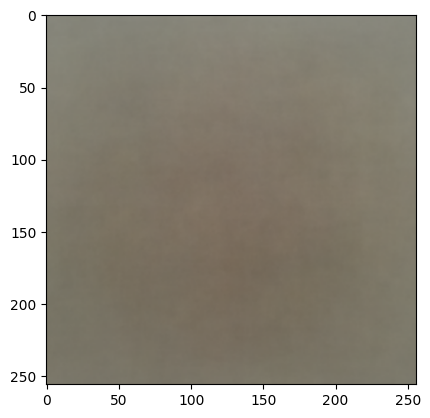

In [41]:
# Method 1 for a thousand images
mean_activity_image_sample = np.mean([np.asarray(Image.open(i)) for i in training_images_processed_path[:1000]], axis=0)
plt.imshow(np.int_(mean_activity_image_sample))

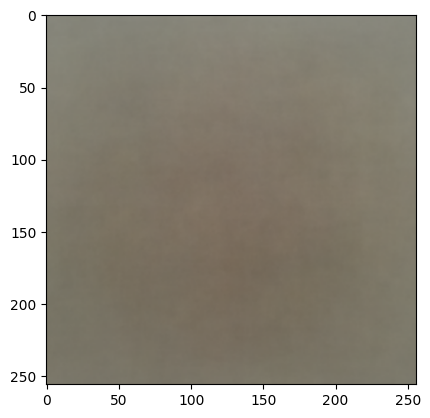

In [42]:
plt.imshow(np.int_(np.asarray(mean_activity_test)))

In [43]:
mean_activity_test == mean_activity_image_sample

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,

#### 1.1 Running Method 3 for all training images

In [44]:
### Method 3: Running mean -> mean
# this method is memory efficient

image_shape = np.asarray(Image.open(training_images_processed_path[0])).shape

image_sums = np.zeros(image_shape)
total_count = 0

for i in tqdm(training_images_processed_path):
    one_image = np.asarray(Image.open(i))

    image_sums += one_image
    total_count += 1
    mean_activity_training = image_sums / total_count

100%|███████████████████████████████| 1261405/1261405 [14:18<00:00, 1470.09it/s]


In [45]:
# saving the mean activity/image as an array
with open("./images/mean_activity_of_all_training_images.npy", "wb") as f:
    np.save(f, mean_activity_training)

In [46]:
# also saving it as a tensor
mean_activity_training_tensor = torch.from_numpy(mean_activity_training)
torch.save(
    mean_activity_training_tensor, 
    "./images/mean_activity_of_all_training_images.pt"
)

Using multiprocessing would have saved me 5-10 minutes but the code is simple & I needn't run it again, so it is okay.

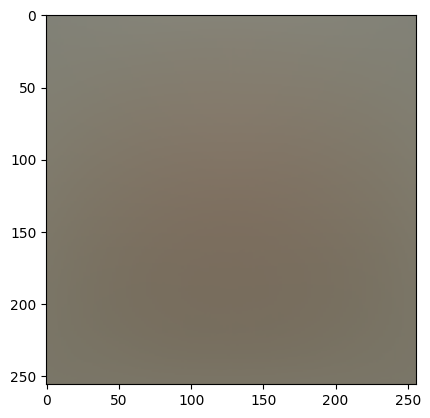

In [49]:
# visualizing the mean image of the entire training set
plt.imshow(np.int_(np.asarray(mean_activity_training)))

## 2. Testing random sampling patches from images

In [187]:
test_image = Image.open(training_images_processed_path[0])

In [8]:
crop_transform = transforms.RandomCrop((224, 224))

Just skimming through [the source code](https://pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#RandomCrop), it seems that `transforms.RandomCrop()` doesn't sample without replacement, which is an issue because the crop size is not that different from the image size, so a non-negligible portion of cropped images would be identical. 

**While the paper doesn't talk at all about the uniqueness of the random crops,** I am assuming that the authors imposed some checks to ensure that their random crops were unique. After all, the purpose of image augmentation is to increase the diversity of training examples, but it is possible that this wasn't a major concern for the authors given the size of the training set. 

I am carrying forward with the assumption that it would be better if the crops are unique, so in the block below, I append only those cropped portions which are unique.

In [21]:
%%timeit -n1 -r1

i = 0
loop_number = []
list_length_change = []
sample_crops = []

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    if random_portion_of_image not in sample_crops:
        sample_crops.append(random_portion_of_image)

    list_length_change.append(len(sample_crops))

4min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The block below is nearly identical as the one above, except I am using a `set()` to ensure only unique crops are saved.

In [14]:
%%timeit -n1 -r1

i = 0
loop_number = []
list_length_change = []
sample_crops = set()

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
    
    sample_crops.add(random_portion_of_image_tuple)

    list_length_change.append(len(sample_crops))

8.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The set method is much faster, so running that:

In [30]:
# using set instead of list is much faster, so using that instead

i = 0
loop_number = []
list_length_change = []
sample_crops = set()

while len(sample_crops) != 1024:
    i += 1
    loop_number.append(i)
    
    random_portion_of_image = crop_transform(test_image)
    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
    
    sample_crops.add(random_portion_of_image_tuple)

    list_length_change.append(len(sample_crops))

I saved the loops and length of the unique images in a list so that I could plot them and see how many loops it takes to sample 1024 unique 224 x 224 sized images from an original image which has the size 256 x 256.

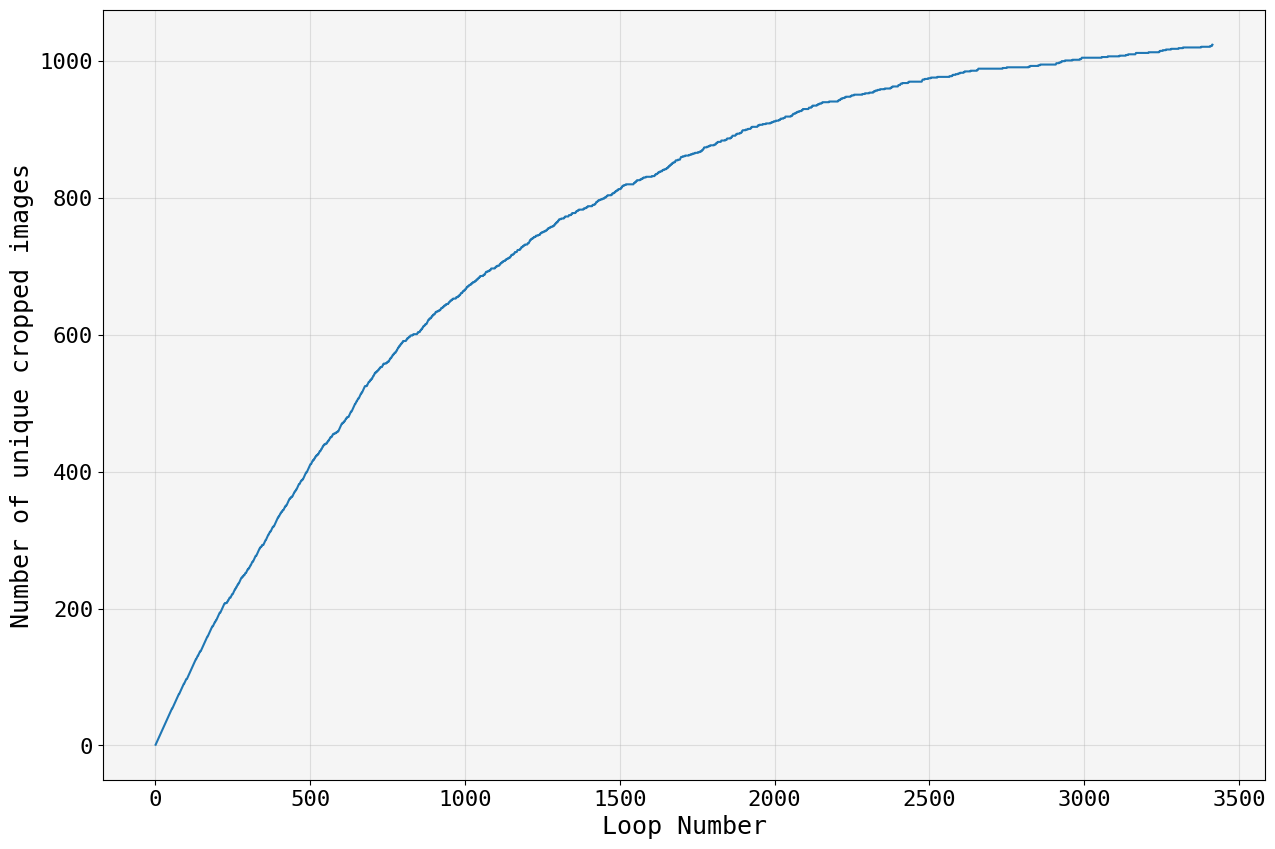

In [66]:
figure, ax = plt.subplots(figsize=(15, 10))
plt.plot(
    loop_number, 
    list_length_change
)

plt.xlabel("Loop Number")
plt.ylabel("Number of unique cropped images")

plt.grid(alpha=0.35)

plt.show()

In [15]:
def tuple_to_image(
    crop_tuple, 
    size=(224, 224)
):
    """
    This function takes the tuple of an image 
    and converts it back to an image using Pillow

    :param 
    """
    pixel_list = list(crop_tuple)
    image = Image.new('RGB', size)
    image.putdata(pixel_list)
    
    return image

In [43]:
%%timeit

sample_crops_list = list(map(tuple_to_image, list(sample_crops)))
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

1.81 s ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tested the above using generator expressions and torch stack + flip functions and the runtime appears to be about the same (~2 seconds) on my device.

In [47]:
# now actually running it
sample_crops_list = list(
    map(tuple_to_image, list(sample_crops))
)
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

len(sample_crops_list)

2048

Next, I want to compile a function using the snippets above which takes an image as the input, randomly samples 1024 unique portions of it, flips them horizontally, and returns a list of 2048 cropped and flipped images.

The issue is that the unique random sampling thing I wrote above takes around 8 seconds to execute and the flipping routine takes around 2 seconds, so that is 10 seconds per image, and for the entire dataset, ~12 million seconds or...

In [27]:
print(f"...{(10 * 1.2 * 1e6) / (24 * 3600):.1f} days!?")

...138.9 days!?


Even after parallel processing (10x reduction in time using a 10-core CPU), the time taken would be exorbitantly high. 

Randomly sampling the images as arrays would be much more faster; I abandoned this initially with the hopes that direct image cropping, given its simplicity, would work. If sampling with replacement was fine, then it would have been much easier!

In [6]:
%%timeit

sample_crops_list = [crop_transform(test_image) for _ in range(1024)]
sample_crops_list.extend([i.transpose(method=Image.FLIP_LEFT_RIGHT) for i in sample_crops_list])

70 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
### Didn't expect much to change below
### just adding the flipped images at once
### performs worse...I thought it would be still ~10 seconds

#%%timeit -n1 -r1

#sample_crops = set()

#while len(sample_crops) != 2048:
#    random_portion_of_image = crop_transform(test_image)
#    random_portion_of_image_flipped = random_portion_of_image.transpose(method=Image.FLIP_LEFT_RIGHT)
    
#    random_portion_of_image_tuple = tuple(random_portion_of_image.getdata())
#    random_portion_of_image_flipped_tuple = tuple(random_portion_of_image_flipped.getdata())
    
#    sample_crops.add(random_portion_of_image_tuple)
#    sample_crops.add(random_portion_of_image_flipped_tuple)

15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### 2.1 Randomly sampling images ~~as arrays~~ using corners

In [9]:
test_image = Image.open(training_images_processed_path[0])

In [10]:
np.asarray(test_image)[:, :, 1]

array([[ 7,  7,  7, ...,  5,  5,  5],
       [ 4,  5,  4, ...,  5,  5,  5],
       [ 2,  2,  3, ...,  5,  5,  5],
       ...,
       [22, 24, 24, ..., 14, 12, 11],
       [21, 22, 23, ..., 15, 14, 12],
       [16, 17, 18, ..., 11, 10,  8]], dtype=uint8)

In [11]:
# total possible 224 x 244 random crops from a 256 x 256 sized image
(256 - 224 + 1) ** 2

1089

In [12]:
# getting all possible left-top corners for 224 x 224 sized patches
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]

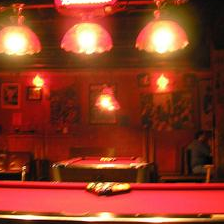

In [13]:
# checking how this method works and visualizing sampled portions
# I timed this, and the average run time is < 50 ms for one image
random_corners = random.sample(left_top_corners, 1024)

### first did it using arrays, later converted to tensors
#Image.fromarray(
#    [np.asarray(test_image)[i:i + 224, j:j+224, :] for i, j in random_corners][1]
#)


# slicing differently because numpy arrays are arranged as (height, width, channels)
# while tensors are arranged as (channels, height, width)
F.to_pil_image(
    [F.pil_to_tensor(test_image)[:, i:i + 224, j:j+224] for i, j in random_corners][1]
)

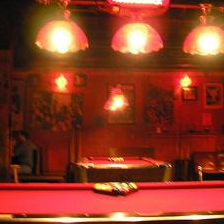

In [14]:
# horizontally flipping the cropped image

### first did it using arrays, later converted to tensors
#Image.fromarray(
#    np.flip([np.asarray(test_image)[i:i + 224, j:j+224, :] for i, j in random_corners][1], 1)
#)

F.to_pil_image(
    torch.flip(
        [F.pil_to_tensor(test_image)[:, i:i + 224, j:j+224] for i, j in random_corners][1], 
        dims=(2,) # the 1st dimension of a numpy array is the 2nd one in a tensor
    )
)

In [15]:
### took a subset to test run the mapping of the function "extract_image_portions"
#training_images_processed_path_subset = training_images_processed_path[:1200]

In [16]:
%%timeit # -r1 -n1

def extract_image_portions(
    image_path, 
):
    random_corners = random.sample(left_top_corners, 1024)

    ### used numpy arrays initially, and tensors later
    #image_portions = [np.asarray(Image.open(image))[i:i + 224, j:j+224, :] for i, j in random_corners] 
    #return image_portions
    
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))
    image_portions = [image_as_tensor[:, i:i + 224, j:j+224] for i, j in random_corners] 
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )
    
    return image_portions

many_image_portions = map(extract_image_portions, training_images_processed_path)

76.8 ns ± 0.688 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


~~The method above seems suspiciously fast; 1024 randomly selected image portions for 1.2 million images in nanoseconds?!~~ `map()`'s execution time is *[lazy](https://stackoverflow.com/questions/20535342/lazy-evaluation-in-python)*, so the suspiciously low runtime makes sense.

Running the code without `%%timeit` (as it causes issues because of how [local variables are re-assigned](https://stackoverflow.com/questions/54922775/using-magic-command-timeit-n1-r1-causes-jupyter-does-not-keep-the-value-of)), and visualizing the output below; the results seem sound.

In [44]:
left_top_corners = [p for p in itertools.product(range(256 - 224 + 1), repeat=2)]

def extract_image_portions(
    image_path,
    left_top_corners=left_top_corners
):
    """
    This function randomly crops 1024 unique 224x224 sized portions of the input image, 
    horizontally flips them, and returns a list containing 2048 images as PyTorch tensors.

    This function can be generalized further to crop N x N portions, or randomly sample D
    amount of top-left corners.
    """
    random_corners = random.sample(left_top_corners, 1024)
    
    image_as_tensor = F.pil_to_tensor(Image.open(image_path))
    image_portions = [image_as_tensor[:, i:i + 224, j:j+224] for i, j in random_corners] 
    image_portions.extend(
        [torch.flip(i, dims=(2,)) for i in image_portions]
    )

    return image_portions

# mapping the function to the entire training set
many_image_portions = map(extract_image_portions, training_images_processed_path)

# creating an iter object of all the image paths
iter_processed_training_images = iter(training_images_processed_path)

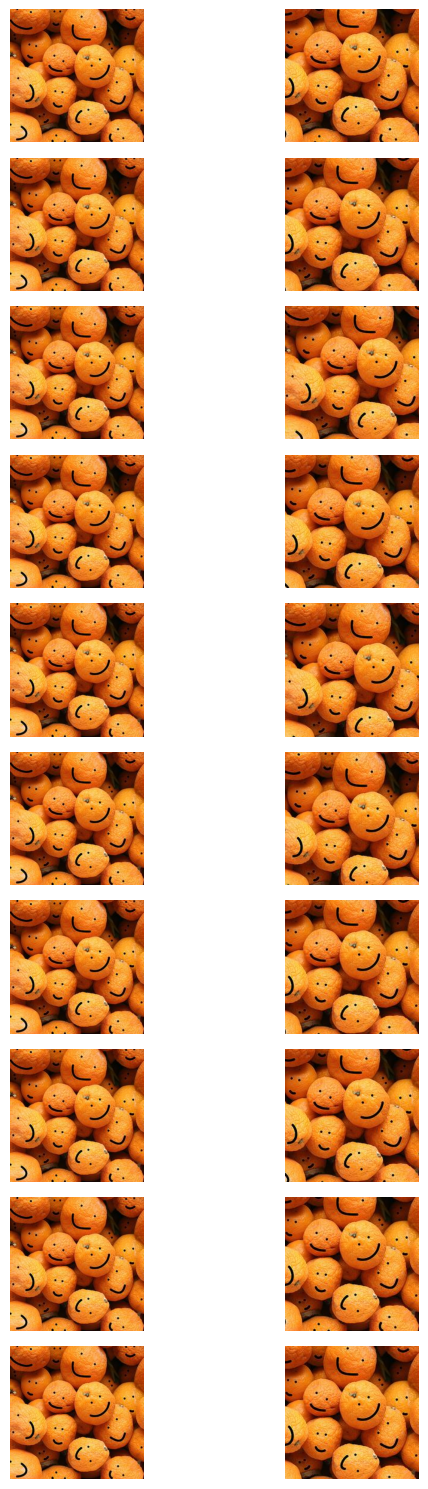

In [17]:
# recycling this code from preprocessing_playground.ipynb 
# some changes within and under zip()

images_to_show = 10

fig, ax = plt.subplots(images_to_show, 2, figsize=(20, 15))

for n, original_image, transformed_image in zip(
    range(images_to_show),
    [next(iter_processed_training_images)] * images_to_show, 
    list(next(many_image_portions))[:images_to_show],
):
    ax[n, 0].imshow(Image.open(original_image))
    ax[n, 1].imshow(F.to_pil_image(transformed_image))
    
    ax[n, 0].axis('off')
    ax[n, 1].axis('off')

plt.subplots_adjust(wspace=-1, hspace=0) 
plt.tight_layout()
plt.show()

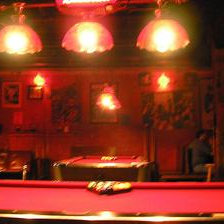

In [201]:
### double checking that the images are flipped properly

test_image_crops_and_flips = extract_image_portions(training_images_processed_path[0])
F.to_pil_image(test_image_crops_and_flips[0])

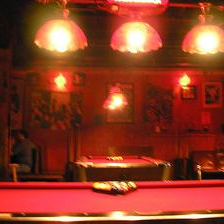

In [203]:
F.to_pil_image(test_image_crops_and_flips[1024])

In hindsight, I got too anchored by the first approach and trying to make it work and finding ways to shave off a few seconds, when I should have abandoned it after the third try. To be fair, I was imagining some very complex array slicing for 1.2 million images and not simply sampling the left-top image coordinates. I was also hung up trying to store the newly generated 2048 * (batch of images or all training images) in memory before passing them, but `torch.utils.data.DataLoader` should be able to handle this on the fly.

## 3. Principal Component Analysis (PCA) of RGB Pixel Values

In [198]:
# taking ~1/1000 of the training images to test PCA and the runtime
training_images_processed_path_subset = training_images_processed_path[:1200]

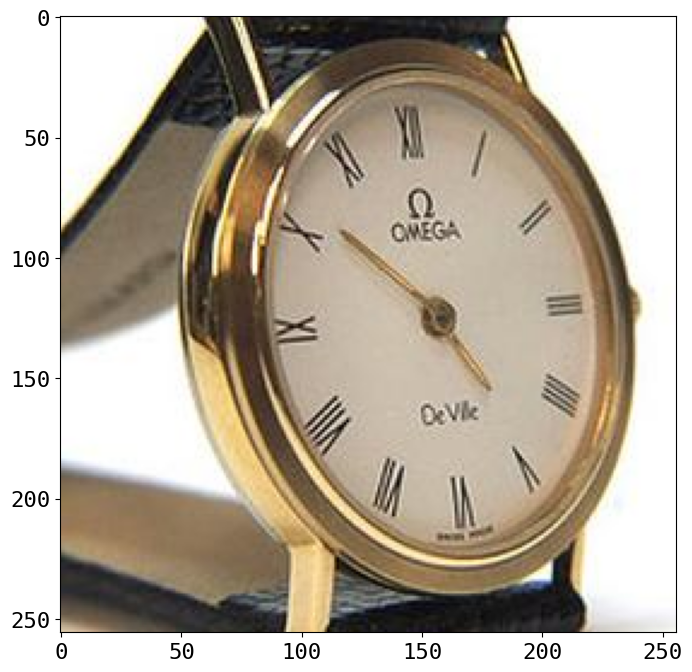

In [199]:
plt.imshow(
    torch.permute(
        F.pil_to_tensor(
            Image.open(training_images_processed_path_subset[-1])
        ),
        (1, 2, 0)
    )
)

#### 3.1 Testing PCA on a small subset 

In [200]:
# this function prepares the tensor for the PCA analysis by converting stacking
# all the R, G, and B pixels of an image in individual columns 

def prep_data_for_pca(
    image_path,
    mean_activity
):
    opened_image = Image.open(image_path)
    prepped_tensor = F.pil_to_tensor(opened_image)

    # subtracting the mean activity of the training set
    # since this is a pre-processing step, it should be done 
    # before the augmentation

    # I saved the mean activity with dimension (256, 256, 3)
    if mean_activity.shape != (3, 256, 256):
        mean_activity = mean_activity.permute(2, 0, 1)
    prepped_tensor = prepped_tensor - mean_activity
    
    # reshaping from (channel, height, width) to (height, width, channel) 
    prepped_tensor = prepped_tensor.permute(1, 2, 0)

    # and then to (height * width, channel)
    prepped_tensor = prepped_tensor.reshape(-1, 3)

    # converting to dtype int16 to reduce the amount of space and 
    # support storage of -ve integers which may show up during the PCA
    prepped_tensor = prepped_tensor.to(torch.int16)

    return prepped_tensor

In [201]:
# defining functions for performing the PCA and finding the multiples

def pca_to_eigenv_star(
    stacked_data
):
    # three components for the three channels
    n_components = 3

    pca_estimator = decomposition.PCA(n_components=n_components)
    scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(stacked_data)
    pca_estimator.fit(scaled_data)
    
    components = pca_estimator.components_
    explained_variance = pca_estimator.explained_variance_
    covariance_matrix = components.T @ np.diag(explained_variance) @ components
    
    eigenvalues, eigenvectors = eig(covariance_matrix)

    return eigenvalues, eigenvectors


def pca_to_multiples(
    eigenvalues, 
    eigenvectors
):
    random_alphas = np.random.normal(loc=0.0, scale=0.1, size=3)
    multiples = eigenvectors @ (eigenvalues * random_alphas)
    return multiples

In [202]:
# loading the saved mean activity from section 1.1
mean_activity_all_training = torch.load("./images/mean_activity_of_all_training_images.pt")

In [203]:
subset_for_pca = [
    prep_data_for_pca(
        i, mean_activity_all_training
    ) for i in training_images_processed_path_subset
]

In [204]:
subset_for_pca[0].shape

torch.Size([65536, 3])

In [205]:
stacked_subset_for_pca = torch.vstack(subset_for_pca)
stacked_subset_for_pca.element_size() * stacked_subset_for_pca.nelement() / 1024 ** 2

450.0

In [206]:
pca_to_multiples(
    pca_to_eigenv_star(stacked_subset_for_pca)[0],
    pca_to_eigenv_star(stacked_subset_for_pca)[1],
)

array([-0.05929756, -0.06410531, -0.06992353])

**The blueprint of the procedure seems right, now trying to do the same on the entire dataset:**

In [196]:
# unsurprisingly the bottom doesn't work due 
# to memory constraints but I had to try

#all_data_pca = [prep_data_for_pca(i) for i in training_images_processed_path]
#all_stacked_for_pca = torch.vstack(all_data_pca)
#pca_to_multiples(all_stacked_for_pca)

In [13]:
def chunkify(list_of_things, cores):
    quotient, remainder = divmod(len(list_of_things), cores)

    chunks = [list_of_things[quotient * n:quotient * (n + 1)] for n in range(cores)]
    chunks[-1].extend(list_of_things[-remainder:])

    return chunks

n_chunks = 1000 # 75
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

In [104]:
# should be equal to 1261405
print("Total images in all chunks:", np.sum([len(i) for i in image_paths_as_many_chunks]))

Total images in all chunks: 1261405


In [105]:
all_stacked_for_pca = [
    prep_data_for_pca(i, mean_activity_all_training) for i in image_paths_as_many_chunks[0]
]
all_stacked_for_pca = torch.vstack(all_stacked_for_pca)

In [106]:
# to check the size of a chunk of the tensor
size_in_bytes = all_stacked_for_pca.element_size() * all_stacked_for_pca.nelement()

print(f"The size of 1/{n_chunks}th of the dataset as tensors is {size_in_bytes / (1024 ** 3):.2f} GBs.")

The size of 1/1000th of the dataset as tensors is 0.46 GBs.


In [11]:
### attempted stacking them sequentially but obviously the memory runs out

#for i in tqdm(image_paths_as_many_chunks[1:]):
#    temp_prepped = [prep_data_for_pca(j, mean_activity_all_training) for j in i]
#    temp_prepped2 = torch.vstack(temp_prepped)
#    all_stacked_for_pca = torch.vstack((all_stacked_for_pca, temp_prepped2))
#    del temp_prepped
#    del temp_prepped2

Below, I was testing if saving the data from the tensors as a feather or parquet file reduced the file size substantially.

**Conclusion**: it does *not*.

In [207]:
#test_pl = pl.DataFrame({
#    "R": all_stacked_for_pca[:, 0].tolist(),
#    "G": all_stacked_for_pca[:, 1].tolist(),
#    "B": all_stacked_for_pca[:, 2].tolist(),
#})

In [35]:
#test_pl.write_parquet("sample_data.parquet", compression="zstd") #.estimated_size("gb")

In [36]:
#torch.save(all_stacked_for_pca, "sample_data.pt")

#### 3.2 Testing how incremental PCA performs 
(and if its results are identical to the ones from the regular PCA)

In [107]:
### tested incremental PCA on 1/1000th of the dataset
### the chunks here aren't neatly divided, but that is ok

scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_stacked_for_pca)

In [108]:
def data_generator(scaled_data, batch_size):
    for i in range(0, len(scaled_data), batch_size):
        yield scaled_data[i:i + batch_size]

In [109]:
ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1)

iteration = 0
for batch in data_generator(scaled_data, batch_size=int(all_stacked_for_pca.shape[0] / 10)):
    ipca.partial_fit(batch)
    iteration += 1
    print(f"Iteration #{iteration} done.")

Iteration #1 done.
Iteration #2 done.
Iteration #3 done.
Iteration #4 done.
Iteration #5 done.
Iteration #6 done.
Iteration #7 done.
Iteration #8 done.
Iteration #9 done.
Iteration #10 done.
Iteration #11 done.


In [110]:
components = ipca.components_
explained_variance = ipca.explained_variance_
covariance_matrix = components.T @ np.diag(explained_variance) @ components

eigenvalues, eigenvectors = eig(covariance_matrix)

In [111]:
eigenvalues2, eigenvectors2 = pca_to_eigenv_star(all_stacked_for_pca)

In [112]:
random_alphas = np.random.normal(loc=0.0, scale=0.1, size=3)
sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)
sample_results_from_regular_pca = eigenvectors2 @ (eigenvalues2 * random_alphas)
print(np.isclose(sample_results_from_incremental_pca, sample_results_from_regular_pca))
print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")
print(f"Multiples from PCA: {np.round(sample_results_from_regular_pca, 4)}")

[ True  True  True]
Multiples from IPCA: [ 0.0004 -0.0066 -0.002 ]
Multiples from PCA: [ 0.0004 -0.0066 -0.002 ]


It seems that the results from regular and incremental PCA are identical, which is great. 

However, **a few notes/issues I ran into while tinkering with the code above:**
1. `StandardScaler()` consumes >75% of the runtime (thanks to a healthy use of `%%timeit` to measure this). The runtime for `PCA` and `Incremental PCA` is nearly identical, although the former is marginally faster.
2. Incrementally scaling the data isn't supported by `StandardScaler()`. This is an issue even for just 1/100th of the dataset, roughly 12000 images, the number of items in R, G, and B columns is greater than 800 billion. So, for 1.2 million images, this number is 100x higher and I can't stack or pass them all at once to the scaling function.
    - I wrote a simple robust scaling function, but
        - `torch.quantile()` would crash the kernel for 1/100th of the dataset (due to my machine's memory constraints)
            - One reason it doesn't accept such "large" sized arrays and is slow is because the algorithm also returns index positions, which slows it down
            - Another reason it leads to memory bloat is because it doesn't support the `torch.int16` dtype, so the tensors have to be converted to `float32`, which requires more memory.
        - I wrote a simple function that found the quantiles by sorting all the elements and then finding the element at the 0.25 * `len(sequence)` and 0.75 `len(sequence)` indices. But in this function I was using python's in-built `sorted()` function which also crashed for tens of billion of items in a sequence.
    - One way now is stacking batches of tensors separately using multiprocessing, and then stacking them all again into one large tensor, and passing this to Incremental PCA.
        - Scaling this data would still be challenging, so I would need to find a way to efficiently scale it before stacking/PCA. 

#### Focusing now on ways to scale the data for PCA

For computing the mean activity of the training set, I used a running mean method which was agnostic to the amount of data being used. I wonder if it is possible to do something similar for scaling the data, either finding it by running a loop through all the data and estimating the median and the quantiles (for robust scaling), or estimating them by randomly sampling a portion of the dataset.

In [179]:
# using the word "running" here which isn't entirely accurate
# thought this idea was inspired by the running mean thing used in part 1
# more close to bootstrapping than finding a running mean
running_medians = []
running_q1 = []
running_q3 = []

total_range_of_rows = range(int(all_stacked_for_pca.shape[0]))
n_random_samples = 100000
total_iterations = 10

for _ in tqdm(range(total_iterations)):
    # selecting n_random_samples amount of random indices
    randomly_chosen_row_nums = np.random.choice(total_range_of_rows, size=n_random_samples, replace=False)

    # extracting rows at those random indices and stacking them as a tensor
    randomly_stacked_subset = torch.vstack([all_stacked_for_pca[i] for i in randomly_chosen_row_nums])

    # torch median also returns indices, which isn't necessary for this test, hence [0]
    median_of_randomly_stacked_subset = torch.median(randomly_stacked_subset, dim=0)[0]

    # torch quantile fails for even 1/1000th of the dataset
    # so using the numpy equivalent here
    q1_of_randomly_stacked_subset = np.percentile(randomly_stacked_subset.numpy(), q=25, axis=0)
    q3_of_randomly_stacked_subset = np.percentile(randomly_stacked_subset.numpy(), q=75, axis=0)

    # saving the computed medians, q1s, and q3s to different lists
    running_medians.append(median_of_randomly_stacked_subset)
    running_q1.append(q1_of_randomly_stacked_subset)
    running_q3.append(q3_of_randomly_stacked_subset)

100%|██████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]


Below, I compare estimated median and quantiles for the R, G, & B rows of ~1200 images:

In [180]:
total_number_of_rows = int(all_stacked_for_pca.shape[0])

median_of_the_entire_tensor = torch.median(all_stacked_for_pca, dim=0)[0]
median_from_sampled_subsets = torch.median(torch.vstack(running_medians), dim=0)[0]

print(f"The median of the entire dataset is: {median_of_the_entire_tensor.numpy()}")
print(
    f"The estimated median of the entire dataset, after selecting\n"
    f"{(100 * n_random_samples / total_number_of_rows):.2f}% of random rows "
    f"for {total_iterations} iterations, is: {median_from_sampled_subsets.numpy()}"
)

The median of the entire dataset is: [ -2  -3 -12]
The estimated median of the entire dataset, after selecting
0.12% of random rows for 10 iterations, is: [ -3  -3 -12]


In [24]:
q1_of_the_entire_tensor = np.percentile(all_stacked_for_pca.numpy(), q=25, axis=0)
q3_of_the_entire_tensor = np.percentile(all_stacked_for_pca.numpy(), q=75, axis=0)

q1_from_sampled_subsets = np.median(np.vstack(running_q1), axis=0)
q3_from_sampled_subsets = np.median(np.vstack(running_q3), axis=0)

print(f"The Q1 value of the entire dataset is: {q1_of_the_entire_tensor}")
print(
    f"The estimated Q1 of the entire dataset, after selecting "
    f"{(100 * n_random_samples / total_number_of_rows):.2f}% of random rows \n"
    f"for {total_iterations} iterations, is: {q1_from_sampled_subsets}"
)
print()
print(f"The Q3 value of the entire dataset is: {q3_of_the_entire_tensor}")
print(
    f"The estimated Q3 of the entire dataset, after selecting "
    f"{(100 * n_random_samples / total_number_of_rows):.2f}% of random rows \n"
    f"for {total_iterations} iterations, is: {q3_from_sampled_subsets}"
)

The Q1 value of the entire dataset is: [-62. -59. -64.]
The estimated Q1 of the entire dataset, after selecting 0.12% of random rows 
for 10 iterations, is: [-62.5 -59.  -64. ]

The Q3 value of the entire dataset is: [59. 55. 59.]
The estimated Q3 of the entire dataset, after selecting 0.12% of random rows 
for 10 iterations, is: [59. 55. 59.]


I am sufficiently happy with this simple test here, as it means scaling the data from just using ~0.1% of the tensor rows is feasible. I ran the loop for different `n_random_samples` numbers, and for 100,000 samples for 10 loops, the results are identical to finding the median or Q1/Q3 value of the entire tensor at once. 

Next, I will slightly customize the loop above so that the tensor subset being sampled is also chosen at random (note that the above test was done on the first 1/1000th portion of the tensor). The estimated median, Q1, and Q3 values will be used for scaling the tensors before they are stored as chunks.

In [10]:
n_chunks = 100
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

In [ ]:
estimated_medians = []
estimated_q1 = []
estimated_q3 = []

n_random_samples = 100000000
total_iterations = 10

# randomly selecting total_iterations number of indices
randomly_select_a_subset = np.random.choice(
    range(len(image_paths_as_many_chunks)),
    size=total_iterations,
    replace=False
)

for num in tqdm(range(total_iterations)):
    # the index above is used below to select one of n_chunks
    all_stacked_for_pca = [
        prep_data_for_pca(i, mean_activity_all_training) 
        for i in image_paths_as_many_chunks[randomly_select_a_subset[num]]
    ]
    all_stacked_for_pca = torch.vstack(all_stacked_for_pca)
    
    # selecting n_random_samples amount of random indices
    total_range_of_rows = range(int(all_stacked_for_pca.shape[0]))
    randomly_chosen_row_nums = np.random.choice(total_range_of_rows, size=n_random_samples, replace=False)

    # extracting rows at those random indices and stacking them as a tensor
    randomly_stacked_subset = torch.vstack([all_stacked_for_pca[i] for i in randomly_chosen_row_nums])

    # torch median also returns indices, which isn't necessary for this test, hence [0]
    median_of_randomly_stacked_subset = torch.median(randomly_stacked_subset, dim=0)[0]

    # torch quantile fails for even 1/1000th of the dataset
    # so using the numpy equivalent here
    q1_of_randomly_stacked_subset = np.percentile(randomly_stacked_subset.numpy(), q=25, axis=0)
    q3_of_randomly_stacked_subset = np.percentile(randomly_stacked_subset.numpy(), q=75, axis=0)

    # saving the computed medians, q1s, and q3s to different lists
    estimated_medians.append(median_of_randomly_stacked_subset)
    estimated_q1.append(q1_of_randomly_stacked_subset)
    estimated_q3.append(q3_of_randomly_stacked_subset)

  0%|                                                       | 0/10 [00:00<?, ?it/s]

In [215]:
print(
    "Estimated Median:", torch.median(torch.vstack(estimated_medians), dim=0)[0].numpy(), "\n",
    "Estimated Q1:", np.median(np.vstack(estimated_q1), axis=0), "\n",
    "Estimated Q3:", np.median(np.vstack(estimated_q3), axis=0), 
)

Estimated Median: [ -1  -3 -13] 
 Estimated Q1: [-60.  -58.5 -64.5] 
 Estimated Q3: [59. 54. 57.]


The code for estimating the quantiles seems sound! 

Here, I can't compare it with the median or the quantiles for even 1/100th of the dataset because it would occupy too much memory, but the results aren't that different from the smaller run above.

I cleaned up and ran the code simultaneously 10 times using `./pca_business/quantiles_for_data_scaling.py`. The estimated quantiles from each run were saved in a `.csv`, and the median of all the runs (best estimate of the true value of the quantiles) were saved as tensors.

#### ~~Focusing now on just stacking the tensors and saving them~~

I abandoned this direction soon after because I found a much better way to do the PCA without having to first stack all the (256 x 256 x _N_, 3) shaped tensors.

In [207]:
# first modifying the prep data function from above to include robust scaling 
# using the computed quantiles from quantiles_for_data_scaling.py

def robust_scaling(
    data,
    quantiles
):
    q1_values, median_values, q3_values = quantiles
    return (data - median_values) / (q3_values - q1_values)
    

def prep_data_for_pca(
    image_path,
    mean_activity,
    quantiles
):  
    opened_image = Image.open(image_path)
    prepped_tensor = F.pil_to_tensor(opened_image)

    q1_values, median_values, q3_values = quantiles
    
    # subtracting the mean activity of the training set
    # since this is a pre-processing step, it should be done 
    # before the augmentation

    # I saved the mean activity with dimension (256, 256, 3)
    if mean_activity.shape != (3, 256, 256):
        mean_activity = mean_activity.permute(2, 0, 1)
    prepped_tensor = prepped_tensor - mean_activity
    
    # reshaping from (channel, height, width) to (height, width, channel) 
    prepped_tensor = prepped_tensor.permute(1, 2, 0)

    # and then to (height * width, channel)
    prepped_tensor = prepped_tensor.reshape(-1, 3)

    # converting to dtype int16 to reduce the amount of space and 
    # support storage of -ve integers which may show up during the PCA
    prepped_tensor = prepped_tensor.to(torch.int16)

    # scaling the prepped tensor based on the quantiles found 
    # using quantiles_for_data_scaling.py
    prepped_tensor = robust_scaling(prepped_tensor, quantiles)

    return prepped_tensor

In [7]:
estimates_q1s = torch.load("./pca_business/best_estimated_q1s.pt")
estimated_medians = torch.load("./pca_business/best_estimated_medians.pt")
estimates_q3s = torch.load("./pca_business/best_estimated_q3s.pt")

In [8]:
tuple_of_quantiles = (
    estimates_q1s,
    estimated_medians,
    estimates_q3s
)

tuple_of_quantiles

(tensor([[-61, -58, -64]], dtype=torch.int16),
 tensor([[ -2,  -4, -13]], dtype=torch.int16),
 tensor([[58, 53, 56]], dtype=torch.int16))

In [103]:
n_chunks = 1000
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

first_stack_for_pca = [
    prep_data_for_pca(i, mean_activity_all_training, tuple_of_quantiles) 
    for i in image_paths_as_many_chunks[0]
]
first_stack_for_pca = torch.vstack(first_stack_for_pca)

In [100]:
out_f32 = robust_scaling(first_stack_for_pca, tuple_of_quantiles)
out_f16 = robust_scaling(first_stack_for_pca, tuple_of_quantiles).to(torch.bfloat16)

print(f"{torch.max(out_f16 - out_f32).item() * 100:.4f}%")

0.0243%


In [52]:
all_stacked_for_pca.shape

torch.Size([82640896, 3])

In [105]:
n_chunks = 500
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

In [ ]:
#sample_chunks = 5
#
#total_images_in_sample = np.sum([len(i) for i in image_paths_as_many_chunks[:sample_chunks]]).item()
#final_tensor_shape = (256 * 256 * total_images_in_sample, 3)
#
## creating a memory-mapped array
#sampled_stacked_array = np.memmap(
#    "./pca_business/sample_stacked.dat",
#    dtype='float16', # float16 because the worst loss of precision compared to float32 is OOM 10^-5 
#    mode='w+', 
#    shape=final_tensor_shape
#)
#
#for num in tqdm(range(sample_chunks)):
#    subset_stacked_for_pca = [
#        prep_data_for_pca(i, mean_activity_all_training, tuple_of_quantiles) 
#        for i in image_paths_as_many_chunks[num]
#    ]
#    subset_stacked_for_pca = torch.vstack(subset_stacked_for_pca).numpy()
#
#    stacked_subset_shape = all_stacked_for_pca.shape
#    # writing the processed chunk to the memory-mapped array
#    start_i = num * stacked_subset_shape[0]
#    end_i = (num + 1) * stacked_subset_shape[0]
#    subset_stacked_for_pca[start_i:end_i] = subset_stacked_for_pca

#### Revisting incremental PCA

One crucial thing I should verify is the output of the PCA when using `StandardScaler()` vs. my robust scaling function; they should be at least nearly identical.

In [17]:
# first modifying the prep data function from above to include robust scaling 
# using the computed quantiles from quantiles_for_data_scaling.py

mean_activity_all_training = torch.load("./images/mean_activity_of_all_training_images.pt")

def robust_scaling(
    data,
    quantiles
):
    q1_values, median_values, q3_values = quantiles
    return (data - median_values) / (q3_values - q1_values)

def standard_scaling(
    data,
    quantiles
):
    mean, standard_deviation = quantiles

    mean = torch.from_numpy(mean)
    standard_deviation = torch.from_numpy(standard_deviation)
    # mean = torch.mean(data.to(torch.float32), dim=0)
    # standard_deviation = torch.std(data.to(torch.float32), dim=0)
    return (data - mean) / standard_deviation
    

def prep_data_for_pca(
    image_path,
    quantiles,
    scaling_function=standard_scaling,
    mean_activity=mean_activity_all_training,
    scaling_bool=True,
):
    opened_image = Image.open(image_path)
    prepped_tensor = F.pil_to_tensor(opened_image)
    
    # subtracting the mean activity of the training set
    # since this is a pre-processing step, it should be done 
    # before the augmentation

    # I saved the mean activity with dimension (256, 256, 3)
    if mean_activity.shape != (3, 256, 256):
        mean_activity = mean_activity.permute(2, 0, 1)
    prepped_tensor = prepped_tensor - mean_activity
    
    # reshaping from (channel, height, width) to (height, width, channel) 
    prepped_tensor = prepped_tensor.permute(1, 2, 0)

    # and then to (height * width, channel)
    prepped_tensor = prepped_tensor.reshape(-1, 3)

    # converting to dtype int16 to reduce the amount of space and 
    # support storage of -ve integers which may show up during the PCA
    prepped_tensor = prepped_tensor.to(torch.int16)

    # scaling the prepped tensor based on the quantiles found 
    # using quantiles_for_data_scaling.py
    if scaling_bool:
        prepped_tensor = scaling_function(prepped_tensor, quantiles)

    return prepped_tensor

In [159]:
n_chunks = 1000
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

map_of_prepped_data = map(prep_data_for_pca, image_paths_as_many_chunks[0])

# using robust scaling
subset_for_pca2 = [prep_data_for_pca(i, scaling_function=robust_scaling) for i in image_paths_as_many_chunks[0]]
stacked_subset_for_pca2 = torch.vstack(subset_for_pca2)

In [160]:
scaler = StandardScaler()
stacked_subset_for_pca3 = scaler.fit_transform(stacked_subset_for_pca2)

In [153]:
iteration_count = 0
ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1) #len(stacked_subset_for_pca2) // 10)

for batch in data_generator(stacked_subset_for_pca2, batch_size=int(stacked_subset_for_pca2.shape[0] / 10)):
    iteration_count += 1 
    #print(i)

    ipca.partial_fit(batch)

In [154]:
eigenvalues2, eigenvectors2 = pca_to_eigenv_star(stacked_subset_for_pca2)

In [155]:
components = ipca.components_
explained_variance = ipca.explained_variance_
covariance_matrix = components.T @ np.diag(explained_variance) @ components

eigenvalues, eigenvectors = eig(covariance_matrix)

In [156]:
random_alphas = np.random.normal(loc=0.0, scale=0.1, size=3)

sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)
sample_results_from_regular_pca = eigenvectors2 @ (eigenvalues2 * random_alphas)

print(np.isclose(sample_results_from_incremental_pca, sample_results_from_regular_pca, rtol=1e-4))
print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")
print(f"Multiples from PCA: {np.round(sample_results_from_regular_pca, 4)}")

[False False False]
Multiples from IPCA: [-0.1678 -0.1751 -0.1613]
Multiples from PCA: [-0.4224 -0.4218 -0.3959]


**Not good.** Robust scaling leads to different PCA results . . .

In [ ]:
# this array was scaled using StandardScaler()
stacked_subset_for_pca3[:10]

array([[-1.32271977, -0.99351228, -0.70242553],
       [-1.32271977, -0.99351228, -0.70242553],
       [-1.35976494, -0.99351228, -0.72367833],
       [-1.37211333, -0.97557824, -0.72367833],
       [-1.40915849, -0.97557824, -0.74493118],
       [-1.43385539, -0.99351228, -0.76618398],
       [-1.44620378, -0.97557824, -0.76618398],
       [-1.44620378, -0.97557824, -0.76618398],
       [-1.45855217, -0.97557824, -0.76618398],
       [-1.45855217, -0.97557824, -0.76618398]])

In [163]:
# now using standard scaling and subtracting a small portion of the scaled data
subset_for_pca2 = [prep_data_for_pca(i, scaling_function=standard_scaling) for i in image_paths_as_many_chunks[0]]
stacked_subset_for_pca2 = torch.vstack(subset_for_pca2)

stacked_subset_for_pca2[:10] - stacked_subset_for_pca3[:10]

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_7982/2141725079.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  stacked_subset_for_pca2[:10] - stacked_subset_for_pca3[:10]


tensor([[1.0094e-05, 7.5803e-06, 5.3590e-06],
        [1.0094e-05, 7.5803e-06, 5.3590e-06],
        [1.0376e-05, 7.5803e-06, 5.5211e-06],
        [1.0471e-05, 7.4434e-06, 5.5211e-06],
        [1.0753e-05, 7.4434e-06, 5.6832e-06],
        [1.0942e-05, 7.5803e-06, 5.8454e-06],
        [1.1036e-05, 7.4434e-06, 5.8454e-06],
        [1.1036e-05, 7.4434e-06, 5.8454e-06],
        [1.1130e-05, 7.4434e-06, 5.8454e-06],
        [1.1130e-05, 7.4434e-06, 5.8454e-06]], dtype=torch.float64)

In [177]:
torch.std(torch.from_numpy(stacked_subset_for_pca3) - stacked_subset_for_pca2, dim=0).numpy()

array([7.63089624e-06, 7.62978948e-06, 7.62914363e-06])

In [177]:
torch.std(torch.from_numpy(stacked_subset_for_pca3) - stacked_subset_for_pca2, dim=0).numpy()

array([7.63089624e-06, 7.62978948e-06, 7.62914363e-06])

For virtually identical results, I need to use a standard scaling routine; I assumed that robust scaling wouldn't lead to noticeable differences in IPCA's output. I will now try to estimate the mean and standard deviation of the dataset using random sampling.

##### **Checking if standard deviation (and mean) estimation using random sampling is sound**

In [26]:
# slightly modified from above
n_chunks = 100
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

subset_for_mustd_test = [
    prep_data_for_pca(i, quantiles=None, scaling_bool=False) for i in image_paths_as_many_chunks[0]
]
subset_for_mustd_test = torch.vstack(subset_for_mustd_test)

sampled_means = []
sampled_std = []

total_range_of_rows = range(int(subset_for_mustd_test.shape[0]))
n_random_samples = 10000000
total_iterations = 10

for _ in tqdm(range(total_iterations)):
    # selecting n_random_samples amount of random indices
    randomly_chosen_row_nums = np.random.choice(total_range_of_rows, size=n_random_samples, replace=False)

    # extracting rows at those random indices and stacking them as a tensor
    randomly_stacked_subset = torch.vstack([subset_for_mustd_test[i] for i in randomly_chosen_row_nums])

    # finding the mean
    mean_of_randomly_stacked_subset = torch.mean(randomly_stacked_subset.to(torch.float32), dim=0).numpy()

    # finding the standard deviation
    std_of_randomly_stacked_subset = torch.std(randomly_stacked_subset.to(torch.float32), dim=0).numpy()

    # saving the computed medians, q1s, and q3s to different lists
    sampled_means.append(mean_of_randomly_stacked_subset)
    sampled_std.append(std_of_randomly_stacked_subset)

100%|██████████████████████████████████████████████| 10/10 [13:46<00:00, 82.61s/it]


In [27]:
total_number_of_rows = int(subset_for_mustd_test.shape[0])

mean_of_the_entire_tensor = torch.mean(subset_for_mustd_test.to(torch.float32), dim=0)
mean_from_sampled_subsets = np.median(np.vstack(sampled_means), axis=0)

std_of_the_entire_tensor = torch.std(subset_for_mustd_test.to(torch.float32), dim=0)
std_from_sampled_subsets = np.median(np.vstack(sampled_std), axis=0)

print(f"The mean of the entire dataset is: {mean_of_the_entire_tensor.numpy()}")
print(
    f"The estimated mean of the entire dataset, after selecting\n"
    f"{(100 * n_random_samples / total_number_of_rows):.2f}% of random rows "
    f"for {total_iterations} iterations, is: {mean_from_sampled_subsets}"
)
print()
print(f"The median of the entire dataset is: {std_of_the_entire_tensor.numpy()}")
print(
    f"The estimated median of the entire dataset, after selecting\n"
    f"{(100 * n_random_samples / total_number_of_rows):.2f}% of random rows "
    f"for {total_iterations} iterations, is: {std_from_sampled_subsets}"
)

The mean of the entire dataset is: [-0.13910343  0.03688383 -0.02955935]
The estimated mean of the entire dataset, after selecting
1.21% of random rows for 10 iterations, is: [-0.12938045  0.04801525 -0.0271793 ]

The median of the entire dataset is: [73.54078  71.359985 75.70194 ]
The estimated median of the entire dataset, after selecting
1.21% of random rows for 10 iterations, is: [73.541855 71.36629  75.70378 ]


In [48]:
print(
    "The percentage difference between the true and estimated means are",
    np.round(
        100 * (mean_of_the_entire_tensor.numpy() - mean_from_sampled_subsets) / mean_of_the_entire_tensor.numpy(),
        2
    )
)

print(
    "The percentage difference between the true and estimated standard deviations are",
    np.round(
        100 * (std_of_the_entire_tensor.numpy() - std_from_sampled_subsets) / std_of_the_entire_tensor.numpy(), 
        4
    )
)

The percentage difference between the true and estimated means are [  6.99 -30.18   8.05]
The percentage difference between the true and estimated standard deviations are [-0.0015 -0.0088 -0.0024]


In [62]:
f"{100 * n_random_samples / (256 * 256 * len(training_images_processed_path)):.4f}%"

'0.0121%'

**Estimating the mean using the random sampling method seems less promising:** Based on the central limit theorem, the sample mean should converge to the true mean, but here, I am only using 0.0121% of the total number of rows (roughly my memory upper cap), which likely explains the siginificant percentage difference between the true and estimated mean values. 

**Estimating the standard deviation using the random sampling method seems reliable, though.**

I will using a running mean calculation to compute the mean, but use the estimated standard deviation from the random sampling method above.

#### Comparing Incremental PCA results using scipy's `StandardScaler()` vs a simple scaling function I wrote 

In [212]:
n_chunks = 1000
image_paths_as_many_chunks = chunkify(training_images_processed_path, n_chunks)

quantiles_standard = (
    mean_from_sampled_subsets,
    std_from_sampled_subsets
)

subset_for_ipca_test = [
    prep_data_for_pca(i, quantiles=quantiles_standard) for i in image_paths_as_many_chunks[0]
]


iteration_count = 0
ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1) #len(stacked_subset_for_pca2) // 10)

for tensor in tqdm(subset_for_ipca_test):
    iteration_count += 1 
    #print(i)

    ipca.partial_fit(tensor)

eigenvalues2, eigenvectors2 = pca_to_eigenv_star(torch.vstack(subset_for_ipca_test))

components = ipca.components_
explained_variance = ipca.explained_variance_
covariance_matrix = components.T @ np.diag(explained_variance) @ components

eigenvalues, eigenvectors = eig(covariance_matrix)

random_alphas = np.random.normal(loc=0.0, scale=0.1, size=3)

sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)
sample_results_from_regular_pca = eigenvectors2 @ (eigenvalues2 * random_alphas)

print(np.isclose(sample_results_from_incremental_pca, sample_results_from_regular_pca, rtol=1e-4))
print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")
print(f"Multiples from PCA: {np.round(sample_results_from_regular_pca, 4)}")

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_7982/1123715546.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (data - mean) / standard_deviation
100%|█████████████████████████████████████████| 1261/1261 [00:04<00:00, 297.97it/s]


[ True  True  True]
Multiples from IPCA: [0.0121 0.0286 0.0285]
Multiples from PCA: [0.0121 0.0286 0.0285]


**The results are ~identical!**

Now, **question:** 
1. Are there any significant speed differences if the data is first scaled and then passed or if the data is scaled inside the loop?
2. Do the incremental PCA results stay the same for both these methods?

I expect the execution speed and results to stay the same, but testing them below —

In [ ]:
quantiles_standard = (
    mean_from_sampled_subsets,
    std_from_sampled_subsets
)

subset_for_ipca_test = [
    prep_data_for_pca(i, quantiles=quantiles_standard) 
    for i in training_images_processed_path[:10000]
]

ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1) #len(stacked_subset_for_pca2) // 10)
for tensor in tqdm(subset_for_ipca_test):
    ipca.partial_fit(tensor)

components = ipca.components_
explained_variance = ipca.explained_variance_
covariance_matrix = components.T @ np.diag(explained_variance) @ components

eigenvalues, eigenvectors = eig(covariance_matrix)

sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)

print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")

100%|███████████████████████████████████████| 10000/10000 [00:33<00:00, 294.92it/s]

Multiples from IPCA: [-0.1384 -0.1243 -0.1213]


In [228]:
quantiles_standard = (
    mean_from_sampled_subsets,
    std_from_sampled_subsets
)

ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1)
for tensor in tqdm(training_images_processed_path[:10000]):
    tensor_scaled = prep_data_for_pca(tensor, quantiles=quantiles_standard) 
    ipca.partial_fit(tensor_scaled)

components = ipca.components_
explained_variance = ipca.explained_variance_
covariance_matrix = components.T @ np.diag(explained_variance) @ components

eigenvalues, eigenvectors = eig(covariance_matrix)

sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)

print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")

100%|███████████████████████████████████████| 10000/10000 [00:40<00:00, 248.15it/s]

Multiples from IPCA: [-0.1384 -0.1243 -0.1213]


In [226]:
# random_alphas = np.random.normal(loc=0.0, scale=0.1, size=3)

In [ ]:
#quantiles_standard = (
#    mean_from_sampled_subsets,
#    std_from_sampled_subsets
#)

#ipca = decomposition.IncrementalPCA(n_components=3, batch_size=1)
#for tensor in tqdm(training_images_processed_path):
#    tensor_scaled = prep_data_for_pca(tensor, quantiles=quantiles_standard) 
#    ipca.partial_fit(tensor_scaled)
#
#components = ipca.components_
#explained_variance = ipca.explained_variance_
#covariance_matrix = components.T @ np.diag(explained_variance) @ components
#
#eigenvalues, eigenvectors = eig(covariance_matrix)
#
#sample_results_from_incremental_pca = eigenvectors @ (eigenvalues * random_alphas)
#
#print(f"Multiples from IPCA: {np.round(sample_results_from_incremental_pca, 4)}")

##### Using running mean to estimate the true mean of the R, G, and B channels

In [153]:
running_mean = torch.zeros(3)
count = 0

for i in tqdm(training_images_processed_path[:1000]):
    prepped_tensor = prep_data_for_pca(i, quantiles=None, scaling_bool=False)
    prepped_tensor_mean = torch.mean(prepped_tensor.to(torch.float32), dim=0)
    
    count += 1
    running_mean += (prepped_tensor_mean - running_mean) / count

100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 692.74it/s]


In [154]:
tensor_subset_mean_check = [
    prep_data_for_pca(i, quantiles=None, scaling_bool=False) for i in training_images_processed_path[:1000]
]

true_mean = torch.mean(torch.vstack(tensor_subset_mean_check).to(torch.float32), dim=0)

In [157]:
# sanity check; the running mean should be equal to the true mean
torch.isclose(running_mean, true_mean)

tensor([True, True, True])

**So, for the flattened R, G, and B channels of all the images in the training set, I will use:**
1. The running mean to determine the means of the three channels
2. Random sampling of several rows to estimate the standard deviations
3. Using the saved means and standard deviation to scale the data and run IPCA
4. Save the eigenvalues and eigenvectors from the IPCA run, which will later be used for adding the multiples to all the pixel values of the images

In the folder `./pca_business`, the scripts `running_mean_for_scaling.py` and `pca_rgb_multiples.py` along with a modified version of `quantiles_for_data_scaling.py` will be used to execute steps 1-4 above. 

### 4. Organizing training and validation label information

#### 4.1 Finding words associated with the images

In [ ]:
# downloading the wordnet corpus
nltk.download('wordnet')

In [4]:
# creating a list of WordNet IDs by removing the "n" and _ followed by the integer and .JPEG
wnids = [int(i.split("_")[0].split("n")[1]) for i in training_images_processed_names]
wnids_w_n = [str(i.split("_")[0]) for i in training_images_processed_names]

# referenced https://www.nltk.org/howto/wordnet.html
# crap = sysnsets
labels_w_crap = [wn.synset_from_pos_and_offset('n', i) for i in wnids]
labels_w_crap_unique = list(np.unique(labels_w_crap))

# getting words corresponding to the synsets
labels_proper = [", ".join(i.lemma_names()).replace("_", " ") for i in labels_w_crap]
labels_proper_unique = list(str(i) for i in np.unique(labels_proper))

In [55]:
# should be equal to 1000 and True
print(len(labels_proper_unique))

print(len(labels_w_crap_unique))
print(labels_w_crap_unique == labels_proper_unique)

999
1000
False


This is confusing. There should be exactly 1000 unique labels, but it seems that two Synsets have the same lemma names... 

In [88]:
# finding lemma names for the 1000 unique Synsets
# one of these will repeat
to_find_the_duplicate = [
    ", ".join(i.lemma_names()).replace("_", " ") for i in labels_w_crap_unique
]

from collections import Counter

print(
    "The repeated item is:",
    [i for i, j in Counter(to_find_the_duplicate).items() if j > 1][0]
)

The repeated item is: cannon


In [89]:
dict_unique_synsets_w_lemmas = {
    i: j for i, j in zip(labels_w_crap_unique, to_find_the_duplicate)
}

for key, value in dict_unique_synsets_w_lemmas.items():
    if value == "cannon":
        print(key)

Synset('cannon.n.02')
Synset('cannon.n.03')


 Turns out there are [multiple synsets for "cannon" in WordNet](http://wordnetweb.princeton.edu/perl/webwn?s=cannon&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=00000000), and two of these are present in the training set. 

#### 4.2 Checking if there are some obvious visual differences between the two types of cannons:

In [92]:
some_dictionary = {i: str(j) for i, j in zip(training_images_processed_names, labels_w_crap)}

In [108]:
cannon_02_images = iter(i for i, j in some_dictionary.items() if some_dictionary[i]=="Synset('cannon.n.02')")

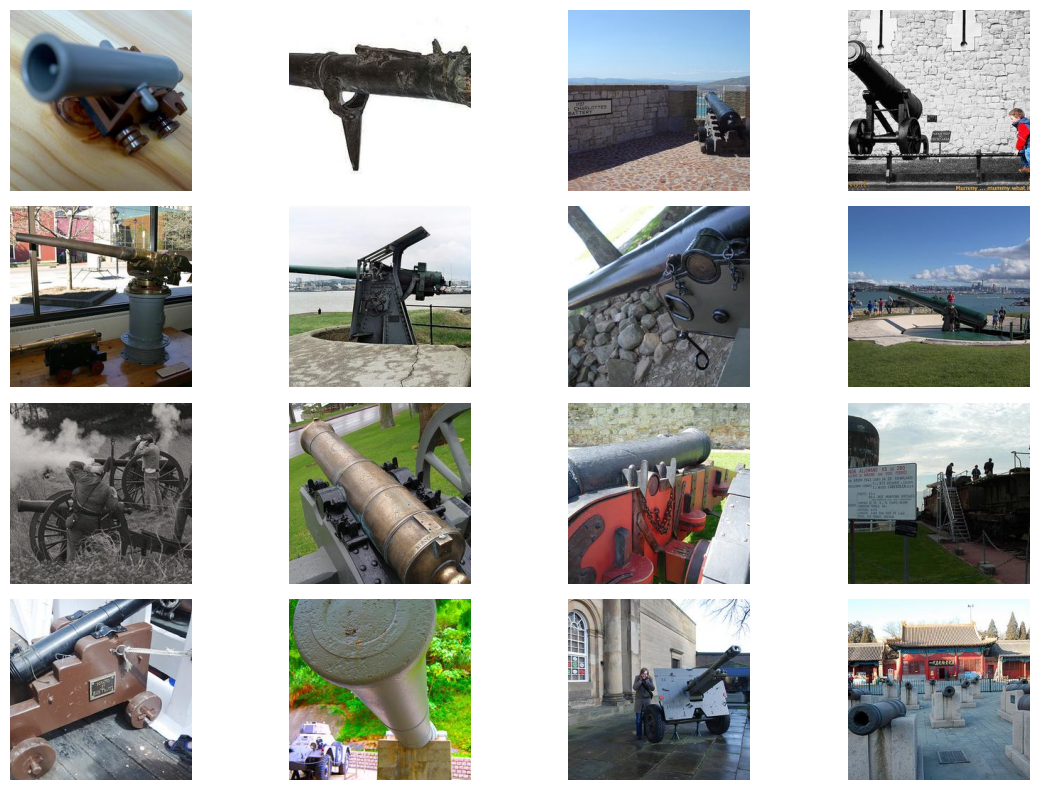

In [119]:
number = 4
fig, ax = plt.subplots(number, number)
ax = ax.flatten()

for n, i in enumerate(cannon_02_images):
    ax[n].imshow(Image.open("./images/training_images_processed/" + i))
    ax[n].axis('off')
    
    if n == number * number - 1:
        break

plt.tight_layout()

In [120]:
cannon_03_images = iter(i for i, j in some_dictionary.items() if some_dictionary[i]=="Synset('cannon.n.03')")

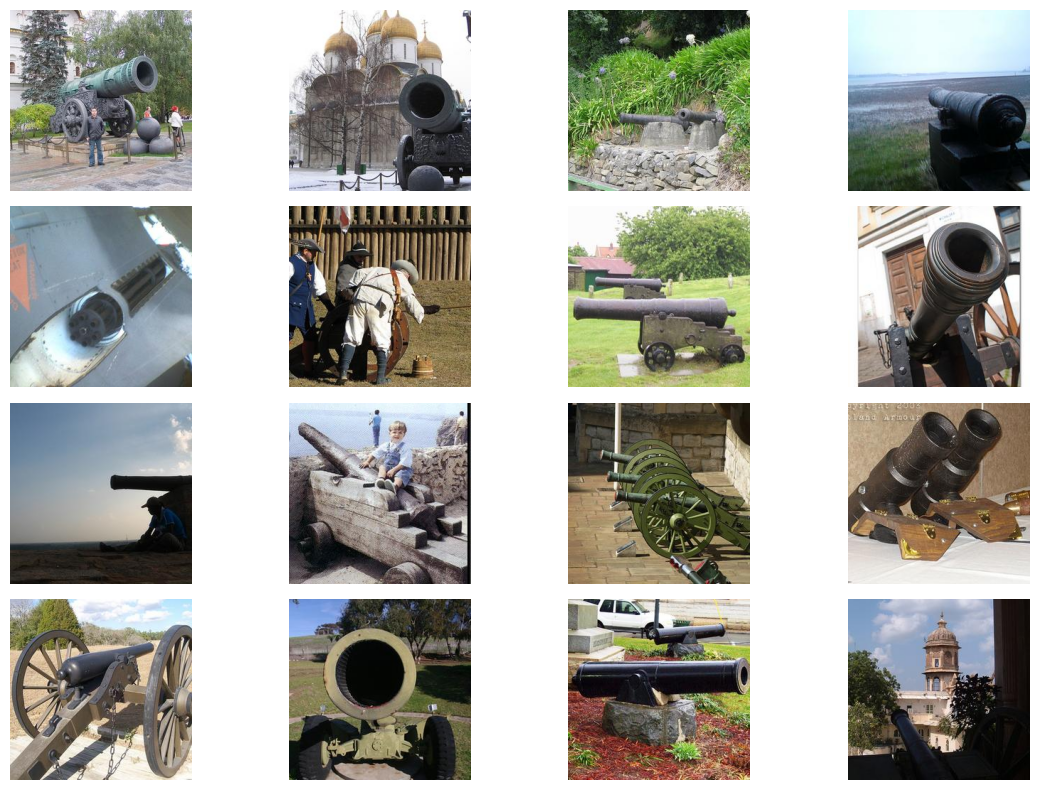

In [125]:
number = 4
fig, ax = plt.subplots(number, number)
ax = ax.flatten()

for n, i in enumerate(cannon_03_images):
    ax[n].imshow(Image.open("./images/training_images_processed/" + i))
    ax[n].axis('off')
    
    if n == number * number - 1:
        break

plt.tight_layout()

At least to me, there aren't any major differences that seem obvious. There are military and old-timey cannons in both sets of images. Both also contain stationary cannons and ones with wheels. Both contain cannons with sometimes humans in the background. It could be interesting to test if the error rate post-training changes if these two supposedly different cannon classes are given the same label. I must be missing something, so I will proceed with the 1000 labels as the authors did.

#### ~~Creating a dataframe with label information and saving it as a CSV~~
**(Updated version at the end)**

In [5]:
# here synsets are converted to strings as objects can't be saved
#labels_w_information = pl.DataFrame({
#    "image_path": training_images_processed_path,
#    "image_name": training_images_processed_names,
#    "wnid": wnids_w_n,
#    "wnid_minus_n": wnids,
#    "synset": [str(i) for i in labels_w_crap],
#    "lemmas": labels_proper,
#})
#
#labels_w_information.write_csv("./images/labels_w_information.csv")

#### 4.3 Now, exploring the `.mat` file for storing validation mappings to labels

In [7]:
devkit_mat_file = scipy.io.loadmat('./devkit-1.0/data/meta.mat')
devkit_mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cost_matrix', 'synsets'])

In [14]:
first_item = devkit_mat_file["synsets"][0]
print(first_item[0][0][0][0])
print(first_item[0][1][0])

1
n07711080


In [16]:
devkit_mat_file["synsets"][0].dtype

dtype([('ILSVRC2010_ID', 'O'), ('WNID', 'O'), ('words', 'O'), ('gloss', 'O'), ('num_children', 'O'), ('children', 'O'), ('wordnet_height', 'O'), ('num_train_images', 'O')])

In [28]:
devkit_mat_file_data = []

for item in devkit_mat_file["synsets"]:
    row = {
        "ILSVRC2010_ID": int(item[0][0][0][0]),
        "WNID": item[0][1][0],
        "words": item[0][2][0],
        "gloss": item[0][3][0],
        "num_children": item[0][4][0][0],
        "children": item[0][5].tolist(),
        "wordnet_height": item[0][6][0][0],
        "num_train_images": item[0][7][0][0]
    }
    devkit_mat_file_data.append(row)

# converting to polars dataframe
devkit_mat_df = pl.DataFrame(devkit_mat_file_data)
print(devkit_mat_df)

shape: (1_676, 8)
┌────────────┬───────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ ILSVRC2010 ┆ WNID      ┆ words      ┆ gloss      ┆ num_child ┆ children  ┆ wordnet_h ┆ num_train │
│ _ID        ┆ ---       ┆ ---        ┆ ---        ┆ ren       ┆ ---       ┆ eight     ┆ _images   │
│ ---        ┆ str       ┆ str        ┆ str        ┆ ---       ┆ list[list ┆ ---       ┆ ---       │
│ i64        ┆           ┆            ┆            ┆ i64       ┆ [null]]   ┆ i64       ┆ i64       │
╞════════════╪═══════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1          ┆ n07711080 ┆ french     ┆ strips of  ┆ 0         ┆ [[]]      ┆ 0         ┆ 1487      │
│            ┆           ┆ fries, fre ┆ potato     ┆           ┆           ┆           ┆           │
│            ┆           ┆ nch-fried  ┆ fried in   ┆           ┆           ┆           ┆           │
│            ┆           ┆ pot…       ┆ deep…      ┆           ┆         

In [33]:
devkit_mat_df_filtered = devkit_mat_df.filter(pl.col("num_train_images") > 0)
devkit_mat_df_filtered

shape: (1_000, 8)
┌────────────┬───────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ ILSVRC2010 ┆ WNID      ┆ words      ┆ gloss      ┆ num_child ┆ children  ┆ wordnet_h ┆ num_train │
│ _ID        ┆ ---       ┆ ---        ┆ ---        ┆ ren       ┆ ---       ┆ eight     ┆ _images   │
│ ---        ┆ str       ┆ str        ┆ str        ┆ ---       ┆ list[list ┆ ---       ┆ ---       │
│ i64        ┆           ┆            ┆            ┆ i64       ┆ [null]]   ┆ i64       ┆ i64       │
╞════════════╪═══════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1          ┆ n07711080 ┆ french     ┆ strips of  ┆ 0         ┆ [[]]      ┆ 0         ┆ 1487      │
│            ┆           ┆ fries, fre ┆ potato     ┆           ┆           ┆           ┆           │
│            ┆           ┆ nch-fried  ┆ fried in   ┆           ┆           ┆           ┆           │
│            ┆           ┆ pot…       ┆ deep…      ┆           ┆           ┆           ┆           │
│ 2          ┆ n07711569 ┆ mashed     ┆ potato     ┆ 0         ┆ [[]]      ┆ 0         ┆ 1245      │
│            ┆           ┆ potato     ┆ that has   ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ been       ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ peeled an… ┆           ┆           ┆           ┆           │
│ 3          ┆ n07767549 ┆ black      ┆ olives     ┆ 0         ┆ [[]]      ┆ 0         ┆ 738       │
│            ┆           ┆ olive,     ┆ picked     ┆           ┆           ┆           ┆           │
│            ┆           ┆ ripe olive ┆ ripe and   ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ cured i…   ┆           ┆           ┆           ┆           │
│ 4          ┆ n03314780 ┆ face       ┆ cosmetic   ┆ 0         ┆ [[]]      ┆ 0         ┆ 1138      │
│            ┆           ┆ powder     ┆ powder for ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ the face   ┆           ┆           ┆           ┆           │
│ 5          ┆ n07739344 ┆ crab       ┆ small sour ┆ 0         ┆ [[]]      ┆ 0         ┆ 1161      │
│            ┆           ┆ apple,     ┆ apple;     ┆           ┆           ┆           ┆           │
│            ┆           ┆ crabapple  ┆ suitable   ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ for…       ┆           ┆           ┆           ┆           │
│ …          ┆ …         ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         │
│ 996        ┆ n04542943 ┆ waffle     ┆ a kitchen  ┆ 0         ┆ [[]]      ┆ 0         ┆ 1132      │
│            ┆           ┆ iron       ┆ appliance  ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ for        ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ baking…    ┆           ┆           ┆           ┆           │
│ 997        ┆ n04517823 ┆ vacuum,    ┆ an         ┆ 0         ┆ [[]]      ┆ 1         ┆ 1644      │
│            ┆           ┆ vacuum     ┆ electrical ┆           ┆           ┆           ┆           │
│            ┆           ┆ cleaner    ┆ home       ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ appliance  ┆           ┆           ┆           ┆           │
│            ┆           ┆            ┆ t…         ┆           ┆           ┆           ┆           │
│ 998        ┆ n03207941 ┆ dishwasher ┆ a machine  ┆ 0         ┆ [[]]      ┆ 0         ┆ 1367      │
│            ┆           ┆ , dish     ┆ for        ┆           ┆           ┆           ┆           │
│            ┆           ┆ washer,    ┆ washing    ┆           ┆           ┆           ┆           │
│            ┆           ┆ dishw…     ┆ dishes     ┆           ┆           ┆           ┆           │
│ 999        ┆ n04070727 ┆ refrigerat ┆ whi

Although, there are 1676 rows, only the first 1000 contain training images, which makes sense as there are a 1000 unique classes. Also, in hindsight, I could have just used this to retrieve the words associated with word net IDs instead of dealing with NLTK.

In [41]:
# just checking if the previously collected WNIDs match with the ones in the table
np.all(np.unique(wnids_w_n) == np.unique(devkit_mat_df_filtered["WNID"]))

np.True_

In [45]:
# creating a list of ILSVRC2010_IDs for all WNIDs
wnid_to_ID = {
    i: j for i, j in zip(
        devkit_mat_df_filtered["WNID"].to_list(),
        devkit_mat_df_filtered["ILSVRC2010_ID"].to_list()
    )
}

ILSVRC2010_ID_list = [wnid_to_ID.get(i) for i in wnids_w_n]

In [54]:
# creating a list of 0-999 integer labels for all WNIDs
wnid_to_madeup_labels = {
    i: j for i, j in zip(
        devkit_mat_df_filtered["WNID"].to_list(),
        range(0, len(devkit_mat_df_filtered["WNID"].to_list()))
    )
}

made_up_labels = [wnid_to_madeup_labels.get(i) for i in wnids_w_n]
len(made_up_labels)

1261405

#### 4.4 Storing all WNIDs and associated label information

In [56]:
# here synsets are converted to strings as objects can't be saved in a CSV
labels_w_information = pl.DataFrame({
    "image_path": training_images_processed_path,
    "image_name": training_images_processed_names,
    "wnid": wnids_w_n,
    "wnid_minus_n": wnids,
    "ILSVRC2010_ID": ILSVRC2010_ID_list,
    "made_up_label": made_up_labels,
    "synset": [str(i) for i in labels_w_crap],
    "lemmas": labels_proper,
})

labels_w_information.write_csv("./images/labels_w_information.csv")